In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid 
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import os
from torchvision import datasets, transforms
%matplotlib inline

In [ ]:
#access dataset on google drive
from google.colab import drive
drive.mount('/content/drive')
proj_dir = '/content/drive/My Drive/data'
data_dir = '/content/drive/My Drive/data/archive'
classes = os.listdir(data_dir)
print(classes)
# meningioma(1), glioma(2), pituitary tumor(3) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['meningioma', 'glioma', 'pituitary']


In [ ]:
'''
pituitary_brains = os.listdir(data_dir+"/3")
print('No. of training examples for pituitary tumor samples:', len(pituitary_brains))
print(pituitary_brains[:5])
'''

In [ ]:
from torchvision.transforms import ToTensor
data_transform = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=data_transform)

In [ ]:
#filtering in appropriate images 
from PIL import Image
path = data_dir+"/pituitary"
for images in os.listdir(path):
    img = Image.open(path+"/"+images)
    if img.width != 512:
        os.remove(path+"/"+images)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) # matplotlib expects 0-dimension to be last. Permute function moves 0-dimention to last dimension for matplotlib

In [ ]:
#split into training data, validating data. 

import time
random_seed = time.time()
torch.manual_seed(random_seed)
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2549, 500)

In [ ]:
#create dataloader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, 32, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#convolutional neural network

def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro, co])
    for i in range (ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,k:j+ck]*kernel)
    return output
                    

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
#architecture of the model
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
            
            nn.Flatten(), 
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3))
        
    def forward(self, xb):
        return self.network(xb)
    

In [ ]:
model = CnnModel()
model
sum([p.numel() for p in model.parameters()])

9646723

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#training on GPU
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)
model = to_device(CnnModel(), device)

In [ ]:
#training process
%%time
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.9210, val_loss: 0.8108, val_acc: 0.6469
Epoch [1], train_loss: 0.6588, val_loss: 0.6143, val_acc: 0.7031
Epoch [2], train_loss: 0.5839, val_loss: 0.5704, val_acc: 0.7340
Epoch [3], train_loss: 0.5285, val_loss: 0.4906, val_acc: 0.7957
Epoch [4], train_loss: 0.4664, val_loss: 0.4333, val_acc: 0.8086
Epoch [5], train_loss: 0.4089, val_loss: 0.3793, val_acc: 0.8273
Epoch [6], train_loss: 0.3427, val_loss: 0.3384, val_acc: 0.8578
Epoch [7], train_loss: 0.2666, val_loss: 0.3317, val_acc: 0.8500
Epoch [8], train_loss: 0.2386, val_loss: 0.4284, val_acc: 0.8273
Epoch [9], train_loss: 0.2100, val_loss: 0.3146, val_acc: 0.8645
Epoch [10], train_loss: 0.1750, val_loss: 0.3978, val_acc: 0.8441
Epoch [11], train_loss: 0.1520, val_loss: 0.3264, val_acc: 0.8570
Epoch [12], train_loss: 0.1308, val_loss: 0.2726, val_acc: 0.8797
Epoch [13], train_loss: 0.1009, val_loss: 0.2338, val_acc: 0.8969
Epoch [14], train_loss: 0.0847, val_loss: 0.3166, val_acc: 0.8930
CPU times: user 15mi

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
crossval = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=train_subsampler, pin_memory=True)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=test_subsampler, pin_memory=True)
    
    #load to GPU
    device = get_default_device()
    to_device(model, device)
    train_dl = DeviceDataLoader(trainloader, device)
    val_dl = DeviceDataLoader(testloader, device)
    model = to_device(CnnModel(), device)

    #training
    num_epochs = 9
    lr = 0.0001
    opt_func = torch.optim.Adam
    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
    crossval.append(history)
    

FOLD 0
--------------------------------
Epoch [0], train_loss: 1.0681, val_loss: 0.7425, val_acc: 0.6410
Epoch [1], train_loss: 0.6994, val_loss: 0.6745, val_acc: 0.7019
Epoch [2], train_loss: 0.5624, val_loss: 0.4723, val_acc: 0.8061
Epoch [3], train_loss: 0.4360, val_loss: 0.4775, val_acc: 0.8269
Epoch [4], train_loss: 0.3909, val_loss: 0.3538, val_acc: 0.8429
Epoch [5], train_loss: 0.3323, val_loss: 0.3085, val_acc: 0.8686
Epoch [6], train_loss: 0.2753, val_loss: 0.2911, val_acc: 0.8702
Epoch [7], train_loss: 0.2291, val_loss: 0.2499, val_acc: 0.9071
Epoch [8], train_loss: 0.1661, val_loss: 0.2248, val_acc: 0.9071
FOLD 1
--------------------------------
Epoch [0], train_loss: 1.0844, val_loss: 0.7150, val_acc: 0.6907
Epoch [1], train_loss: 0.6960, val_loss: 0.6223, val_acc: 0.6955
Epoch [2], train_loss: 0.6087, val_loss: 0.6098, val_acc: 0.6971
Epoch [3], train_loss: 0.5573, val_loss: 0.5317, val_acc: 0.7468
Epoch [4], train_loss: 0.4787, val_loss: 0.5160, val_acc: 0.7356
Epoch [5],

[]

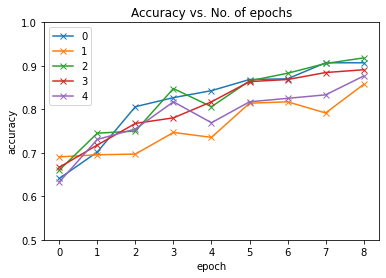

In [ ]:
count = 0
for i in crossval:
  plot_accuracies(i,count)
  count+=1
ax = plt.gca()
plt.legend()
ax.set_ylim([0.5,1])
plt.plot()

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

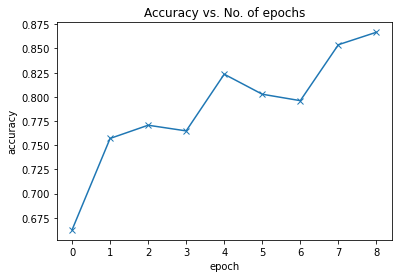

In [ ]:
plot_accuracies(history)

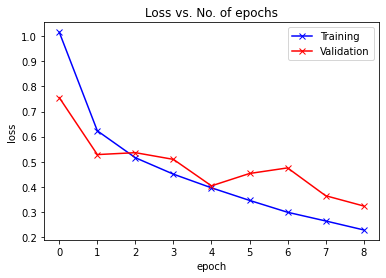

In [ ]:
plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
#save the current model
torch.save(model.state_dict(), '10cnn.pth')
model2 = to_device(CnnModel(), device)
model2.load_state_dict(torch.load('10cnn.pth'))


In [ ]:
#filter images with small size
path = proj_dir+'/test/meningioma'
for images in os.listdir(path):
    img = Image.open(path+"/"+images)
    if img.width != 512:
        os.remove(path+"/"+images)

AttributeError: ignored

In [ ]:
#test on new data
test_dataset = datasets.ImageFolder(proj_dir+'/test', transform=data_transform)
im2, lb = test_dataset[0]

print('true label:', dataset.classes[lb], ' predicted:', predict_image(im2, model))

true label: glioma  predicted: glioma


In [ ]:
#test on test dataset
test_loader = DeviceDataLoader(DataLoader(test_dataset, 32), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7225000262260437, 'val_loss': 2.9754059314727783}

In [ ]:


random_seed = 1
torch.manual_seed(random_seed)
val_size = 500
train_size = len(dataset) - val_size

cs1_train, cs1_val = random_split(dataset, [train_size, val_size])

expected = []
predicted = []

for inputs, labels in cs1_val:
  expected.append(dataset.classes[labels])
  predicted.append(predict_image(inputs, model))



[]

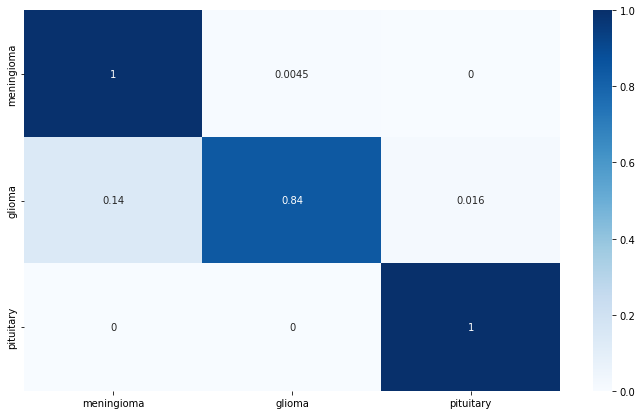

In [ ]:
#Confusion Matrix on original dataset
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import seaborn as sn
import pandas as pd
cf_matrix = confusion_matrix(expected,predicted)
classes = ('meningioma', 'glioma', 'pituitary')
lb_matx = pd.DataFrame(normalize(cf_matrix, axis=1, norm='l1'), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(lb_matx, annot=True, cmap="Blues")
plt.plot()

[]

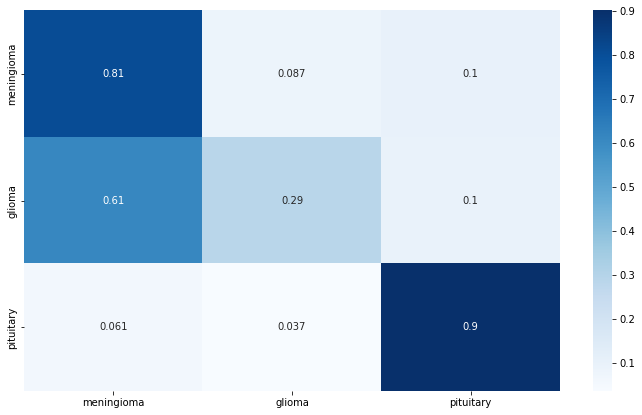

In [ ]:

#Confusion matrix on new dataset
expected = []
predicted = []

for inputs, labels in test_dataset:
  expected.append(dataset.classes[labels])
  predicted.append(predict_image(inputs, model))

cf_matrix = confusion_matrix(expected,predicted)
lb_matx = pd.DataFrame(normalize(cf_matrix, axis=1, norm='l1'), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(lb_matx, annot=True, cmap="Blues")
plt.plot()